# Research Notebook
## Main findings:
* Titles phrased as a question tended to have more user engagement and spent more time in trending but had less overall views.

* There is a negative relationship between the length of time a video is trending and the amount of trending videos that the channel has.

* No relationship was found between user engagement and days trending.



In [90]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import json
from datetime import datetime

In [91]:
US = pd.read_csv("youtube/USvideos.csv")
GB = pd.read_csv("youtube/GBvideos.csv")
CA = pd.read_csv("youtube/CAvideos.csv")
US["region"] = "US"
GB["region"] = "GB"
CA["region"] = "CA"
df = pd.concat([US, GB, CA])
df = US # just using US data for now
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')

# Days Trending
The relationship between days trending and engagement showed no apparent relationship. Engagement was measured as comment count / views. While the number of comments had a small correlation, it was quite insignificant. This  suggets that the trending algorithm is not using the comments to decide what videos trend.

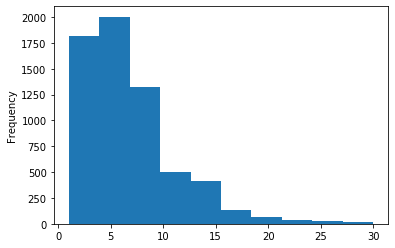

In [92]:
# keep last appearance of trending video
frequencies = df.video_id.value_counts()
frequencies.plot.hist()
trending_start = df.drop_duplicates("video_id", keep="first").set_index("video_id").rename(columns={"views":"starting_views", "likes":"starting_likes"})
trending_end = df.drop_duplicates("video_id", keep="last").set_index("video_id")
trending = pd.concat([trending_end, trending_start[["starting_views","starting_likes"]] ,frequencies], axis=1, sort=False).rename(columns={"video_id":"days_trending"})


In [93]:
# engagement is comments / views
trending["engagement"] = trending.comment_count/trending.views
trending["views_per_day"] = (trending.views-trending.starting_views)/trending.days_trending
trending[trending.views_per_day < 0] = 0 
trending.corr().days_trending

category_id      -0.085441
views             0.260074
likes             0.217892
dislikes          0.063631
comment_count     0.118065
starting_views    0.181504
starting_likes    0.169822
days_trending     1.000000
engagement       -0.038215
views_per_day     0.143846
Name: days_trending, dtype: float64

In [94]:
trending.corr().views_per_day

category_id      -0.154215
views             0.871961
likes             0.750614
dislikes          0.500341
comment_count     0.541382
starting_views    0.601865
starting_likes    0.562058
days_trending     0.143846
engagement       -0.049757
views_per_day     1.000000
Name: views_per_day, dtype: float64

# Title
## Questions 
One method that video creators have used to attract users, is it to phrase the title as a question. This section looks at the effect of using a question in the title. 

In [95]:
trending["question"] = trending.title.str.contains("?", regex=False)
percent_question = float((trending["question"] == True).sum() / trending["question"].count())*100
print("{:8.2f}% of titles are questions".format(percent_question))

    5.63% of titles are questions


5.63% of titles being questions is a significant amount and it is worth exploring its effects on other statistics.

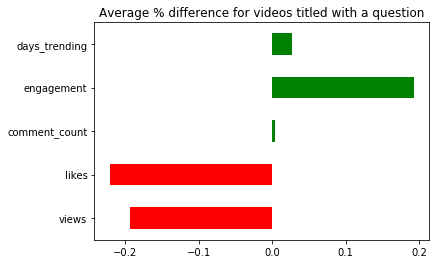

In [96]:
question_views = trending.groupby("question").mean()
question_percentage = (question_views[question_views.index == True] - question_views.mean())/ question_views.mean()
question_percent_series = question_percentage[["views", "likes", "comment_count" ,"engagement" , "days_trending"]].squeeze()
question_percent_series.plot.barh(color=(question_percent_series > 0).map({True: 'g',False: 'r'}), title="Average % difference for videos titled with a question")

In [123]:
question_percent_series

views           -0.193629
likes           -0.221376
comment_count    0.003315
engagement       0.193216
days_trending    0.027268
Name: True, dtype: float64

This plot shows that while likes and views went down, user engagement increased. User engagement was measured as the comment count / views. We also see a slight increase in the days trending of these videos. This suggests that user engagement might play a part in whether a video is trending. 

# Category
## No. of Trends
This section looks at the number of trending videos different channels have and how that effects days trending. 

In [97]:
# only keep channels that had 1 trending video in the period
trending_channels = trending.channel_title.value_counts()
one_trend_channels = trending_channels[trending_channels == 1]
one_trend_mean = trending[trending.channel_title.isin(one_trend_channels.index)].mean()
multi_trend_mean =trending[-trending.channel_title.isin(one_trend_channels.index)].mean()
one_trend_vs_multi_trend_channels = pd.concat({"One Trend":one_trend_mean,"Multiple Trends":multi_trend_mean}, axis=1)
one_trend_vs_multi_trend_channels.T[["views", "likes", "days_trending", "engagement"]]

,views,likes,days_trending,engagement
One Trend,1.817694e+06,40606.721702,6.212689,0.003331
Multiple Trends,2.002431e+06,59756.483280,6.509468,0.004250


This table shows that channels with multiple trending videos tend to have higher views, likes, engagement and days trending. 

In [98]:
trending = pd.merge(trending,
                 trending_channels,
                 left_on = "channel_title", 
                 right_index = True, 
                 how='left').rename(columns={"channel_title_x":"channel_title","channel_title_y":"channel_trends"})

In [99]:
# create dictionary of categories and category ids
id_to_category = {}

with open('youtube/US_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        id_to_category[int(category['id'])] = category['snippet']['title']

with open('youtube/CA_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        id_to_category[category['id']] = category['snippet']['title']
        
with open('youtube/GB_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        id_to_category[category['id']] = category['snippet']['title']

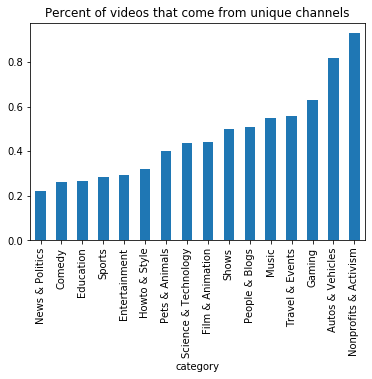

In [102]:
trending["category"] = trending.category_id.map(id_to_category)
category_counts = trending.groupby(["category"]).count().channel_trends
category_unique = trending.groupby(["category"]).nunique().channel_title
(category_unique / category_counts).sort_values().plot.bar(title = "Percent of videos that come from unique channels")

In [143]:
trending[trending["question"]== True].groupby(["category"]).title.count()

category
Autos & Vehicles          1
Comedy                   22
Education                78
Entertainment            95
Film & Animation          6
Gaming                    6
Howto & Style            33
Music                    11
News & Politics          19
Nonprofits & Activism     1
People & Blogs           20
Pets & Animals            9
Science & Technology     38
Sports                   17
Travel & Events           1
Name: title, dtype: int64

In [144]:
trending[trending["question"] == False].groupby(["category"]).median().views

category
Autos & Vehicles          379715.5
Comedy                    795894.5
Education                 342564.0
Entertainment             602127.0
Film & Animation          910969.5
Gaming                   1430025.0
Howto & Style             419822.0
Music                    1096158.0
News & Politics           169511.0
Nonprofits & Activism      32744.0
People & Blogs            402418.0
Pets & Animals            436472.0
Science & Technology      401968.5
Shows                     765522.0
Sports                    407453.5
Travel & Events           401809.0
Name: views, dtype: float64

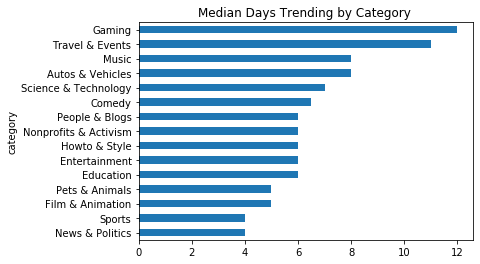

In [149]:
ax = trending[trending["question"]== True].groupby(["category"]).median().days_trending.sort_values().plot.barh(title="Median Days Trending by Category ")
fig = ax.get_figure()

fig.savefig('median_trend_question.png', bbox_inches='tight')

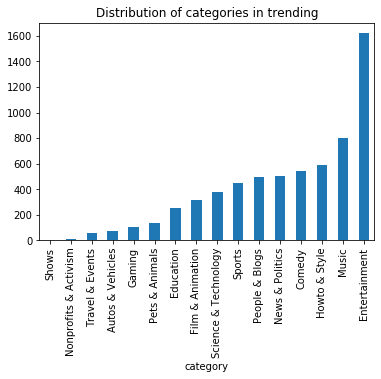

In [108]:
category_counts.sort_values().plot.bar(title = "Distribution of categories in trending")

This first plot shows that there is a large difference between the number of unique trending channels for each category. News, comedy and education are dominated by a small collection of channels while gaming, vehicles and nonprofits have a wider variety of trending channels.

In [122]:
pd.concat([(category_unique / category_counts), category_counts], axis=1).corr()[0].channel_trends

-0.4932059843685006

The relationship between unique trending channels in a category and the amount of trending videos ina category has a negative relationship. This implies that the more popular categories have relatively less unique channels.